## SC4001 Neural Networks and Deep Learning

## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Group Project

Students are to propose and execute a final project on an application or a research issue that is related to neural networks and deep learning. The project can be carried out in a group consisting of no more than three members. Students are to come up with a potential technique for the application or to mitigate the issue, to develop associated codes, and to compare with existing methods. Students may choose, focus, and expand on the project ideas A – F given below.

By the deadline, students are to submit a project report in a .pdf file of ten A4 pages (Arial 10 font) and associated code in a .zip file to NTULearn.

The project report should have the names of the team members on the front page and contain an introduction to the project idea, a review of existing techniques, a description of the methods used, experiments and results, and a discussion. The 10-page limit is exclusive of references, content page, and cover page. The code needs to be commented properly. Make sure the code can be tested easily.

The assessment is based on the project execution (30%), experiments and results (30%), report presentation (15%), and novelty (15%), and peer review (10%. Conducted via Eureka). We apply the same late submission penalty as in Assignment 1, i.e., 5% for each day up to three days.

---

### Topic F. Flowers Recognition

The Oxford Flowers 102 dataset is a collection of 102 flower categories commonly occurring in the United Kingdom. Each class consists of between 40 and 258 images. The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set. The training set and validation set each consist of 10 images per class (a total of 1020 images each). The test set consists of the remaining 6149 images (minimum 20 per class). Some tasks to consider:

1.	Modify some previously published architectures e.g., increase the network depth, reducing their parameters, etc. Explore more advanced techniques such as [deformable convolution](https://pytorch.org/vision/main/generated/torchvision.ops.deform_conv2d.html), [dilated convolution](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) (dilation>1) or [visual prompt](https://github.com/KMnP/vpt) tuning for Transformers.
2.	Analyze the results of using fewer training images, i.e., few-shot learning
3.	Use more advanced transformation techniques such as MixUp (see the [original paper](https://arxiv.org/abs/1710.09412) and its PyTorch implementation [here](https://pytorch.org/vision/master/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py))
4.	Try more advanced loss function such as triplet loss

References:
1.
Nilsback, M-E. and Zisserman, A., “Automated flower classification over a large number of
classes,” in British Machine Vision Conference (BMVC), 2008


Datasets:
1. The dataset is available in TorchVision
https://pytorch.org/vision/main/generated/torchvision.datasets.Flowers102.html
2. The Oxford Flowers 102 Dataset https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

---

### Importing Essential PyTorch and torchvision Libraries

Import various libraries and modules from PyTorch and torchvision that are essential for neural network training and data processing.

---

### CUDA Deep Neural Network Library (`cudnn`)

- **`import torch.backends.cudnn as cudnn`**:
    - `cudnn` is a GPU-accelerated library for deep neural networks. It provides highly tuned implementations for standard routines such as forward and backward convolution, pooling, normalization, and activation layers.
    - Leveraging `cudnn` can lead to significant speedups in training and inference when using NVIDIA GPUs.

### torchvision Library

- **`import torchvision`**:
    - `torchvision` is a library that consists of popular datasets, model architectures, and common image transformations for computer vision.

- **Datasets (`datasets`)**:
    - **`from torchvision import datasets`**:
        - This module provides access to various standard datasets like CIFAR-10, MNIST, etc., making it easier to load and preprocess data.

- **Image Transformations (`transforms`)**:
    - **`from torchvision import transforms`**:
        - This module offers common image transformations like normalization, cropping, and augmentation. These transformations are essential for preprocessing data before feeding it into neural networks.

### Pre-trained Models (`timm`)

- **`import timm`**:
    - timm (pyTorch Image Models) is a PyTorch library that provides a wide variety of pre-trained image models, optimizers, schedulers, data loaders, augmentations, and training/validation scripts.

By importing these libraries and modules, we equip ourselves with the tools necessary for various stages of deep learning, from data preprocessing to model training and evaluation.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import time
import os
from tempfile import TemporaryDirectory
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check the version of PyTorch
print(torch.__version__)

Using device: cuda
2.6.0+cu124


### Set Seed:
- `seed = 10; torch.manual_seed(seed)`: These lines set the seed for generating random numbers. Setting a seed ensures that the random numbers generated are predictable and reproducible. In this case, the seed is set to 10.


In [2]:
# for reproducibility
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

### Data Augmentation, Normalization, and Loading

Preparing the dataset for training and validation by applying necessary transformations, augmentations, and normalization. Additionally, it sets up dataloaders for efficient data feeding into the neural network.

### Data Transformations (`data_transforms`)

- **Training Data**:
    1. **RandomResizedCrop**: Randomly crops the image to size 224x224. This not only helps in resizing the images but also provides a form of data augmentation.
    2. **RandomHorizontalFlip**: Randomly flips the image horizontally, providing another form of data augmentation.
    3. **ToTensor**: Converts the PIL Image to a PyTorch tensor.
    4. **Normalize**: Normalizes the tensor with the provided mean and standard deviation values. These values are often pre-computed from large datasets like ImageNet.

- **Validation Data**:
    1. **Resize**: Resizes the shortest side of the image to 256 while maintaining the aspect ratio.
    2. **CenterCrop**: Crops the center of the image to 224x224.
    3. **ToTensor** and **Normalize**: Same as the training data transformations.

### Load the Oxford Flowers 102 dataset

#### Dataset Directory (`data_dir`)

- Specifies the directory where the dataset is located.

#### Datasets (`datasets`)

- **`from torchvision import datasets`**:
        - This module provides access to various standard datasets like FLOWERS102, etc., making it easier to load and preprocess data.

#### Dataloaders (`dataloaders`)

- Sets up dataloaders for both training and validation data.
    - **batch_size**: Number of samples per batch.
    - **shuffle**: Shuffles the dataset before each epoch for the training set.
	- **num_workers**: Number of subprocesses to use for data loading. Helps in parallelizing the data loading task.

In [3]:
# Data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
data_dir = "./flowers102"
train_dataset = datasets.Flowers102(root=data_dir, split='train', download=True, transform=data_transforms['train'])
val_dataset = datasets.Flowers102(root=data_dir, split='val', download=True, transform=data_transforms['val'])
test_dataset = datasets.Flowers102(root=data_dir, split='test', download=True, transform=data_transforms['test'])

# Create dataloaders
batch_size = 64   # or 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 345M/345M [00:24<00:00, 13.8MB/s]
100%|██████████| 502/502 [00:00<00:00, 706kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 26.4MB/s]


In [4]:
# Verify the data
print(f"Train      dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test       dataset size: {len(test_dataset)}")

Train      dataset size: 1020
Validation dataset size: 1020
Test       dataset size: 6149


### Visualize a few images
Let's visualize a few training images so as to understand the data augmentations.

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))	# convert from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean					# reverse the normalization
    inp  = np.clip(inp, 0, 1)				# clip value to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=12)  		# Set title size
    plt.axis('off')  						# turn off axis to make it cleaner
    plt.pause(0.001)  						# pause a bit so that plots are updated

### Load a Batch and Select a Sample:
- `dataiter = iter (train_loader); inputs, classes = next(dataiter)`: This line loads a batch of images and corresponding classes from the `train_loader`. The `next` function retrieves the next item from the iterator created by `iter(train_loader)`. This will be a batch of images and their corresponding labels. Since `train_loader` shuffles the data at every epoch, this will effectively be a random batch.

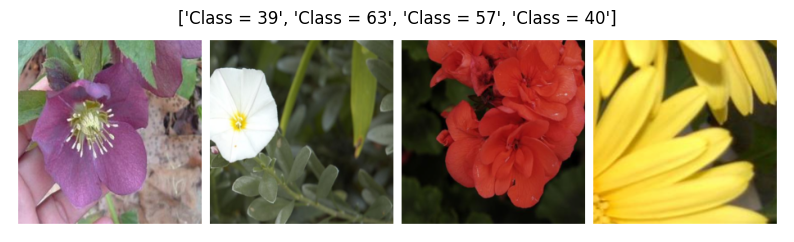

In [8]:
# Get some random training images
dataiter        = iter(train_loader)
inputs, classes = next(dataiter)

# Display some images
out = torchvision.utils.make_grid(inputs[:4], nrow=4, padding=10, pad_value=255)

# Increase figure size
plt.figure(figsize=(10, 10))

imshow(out, title=[f"Class = {class_}" for class_ in classes[:4]])
plt.show()

### Training and evaluating the model

The `train_model` function is designed to train and evaluate a given neural network model over a specified number of epochs.

### Parameters:

- **model**: The neural network model to be trained.
- **criterion**: The loss function.
- **optimizer**: The optimization algorithm.
- **scheduler**: Adjusts the learning rate based on the number of epochs.
- **num_epochs**: Number of times the model will be trained over the entire dataset

#### Process:

1. **Time Tracking**:
    - The start time is recorded to calculate the total training time at the end.

2. **Temporary Directory for Checkpoints**:
    - A temporary directory is created to save the best model parameters during training.

3. **Training, validation and evaluation**:
    - For each epoch:
        - The model is trained on the training dataset and evaluated on the validation dataset.
        - The gradients are zeroed out at the beginning of each batch using `optimizer.zero_grad()`.
        - The model's predictions are compared to the actual labels to compute the loss.
        - Running statistics like loss and accuracy are computed for each epoch.
        - The best model (based on validation accuracy) is saved to the temporary directory.

4. **Results**:
    - After all epochs are completed, the total training time is printed.
    - The best validation accuracy achieved during training is also printed.

5. **Load Best Model**:
    - The best model parameters saved during training are loaded back into the model.

6. **Return**:
    - The trained model with the best parameters is returned.

In [9]:
# Training function
def train_loop(dataloader, model, criterion, optimizer, scheduler):
    size = len(dataloader.dataset)		# Dataset size
    train_loss = 0.0
    train_acc  = 0

    running_loss = 0.0
    running_acc  = 0

    model.train()
    # Iterate over data
    for inputs, labels in dataloader:	# Batch loop
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Backpropagation
        optimizer.zero_grad()			# Zero the parameter gradients

        outputs  = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss     = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_acc  += torch.sum(preds == labels.data)

    scheduler.step()  					# Learning rate scheduler step

    train_loss = running_loss / size
    train_acc  = running_acc.double() / size
    return train_loss, train_acc

In [10]:
# Test function
def test_loop(dataloader, model, criterion):
    model.eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).type(torch.float).sum().item()

    test_loss /= size
    test_acc = correct / size
    return test_loss, test_acc


In [11]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < (self.min_validation_loss - self.min_delta):
            self.min_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [12]:
def train_and_evaluate(model, criterion, optimizer, scheduler, num_epochs=100):
	since = time.time()

	# Create a temporary directory to save training checkpoints
	with TemporaryDirectory() as tempdir:
		best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

		torch.save(model.state_dict(), best_model_params_path)
		best_acc = 0.0

		early_stopper = EarlyStopper(patience=10, min_delta=0)

		tr_loss, tr_acc = [], []
		vl_loss, vl_acc = [], []

		for epoch in range(num_epochs):	# epoch loop
			train_loss, train_acc = train_loop(train_loader, model, criterion, optimizer, scheduler)
			val_loss,   val_acc   = test_loop(val_loader, model, criterion)

			tr_loss.append(train_loss), tr_acc.append(train_acc)
			vl_loss.append(val_loss),   vl_acc.append(val_acc)

			print(f"Epoch {epoch+1:2d}: Train_accuracy: {(100*train_acc):>5.2f}%, Train_loss: {train_loss:.4f}, "
				  f"Validation_accuracy: {(100*val_acc):>5.2f}%, Validation_loss: {val_loss:.4f}")

			if val_acc > best_acc:
				best_acc = val_acc
				torch.save(model.state_dict(), best_model_params_path)

			if early_stopper.early_stop(val_loss):
				print(f"Early stopping triggered at epoch {epoch+1}!")
				break

		time_elapsed = time.time() - since
		print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
		print(f'Best Validation Accuracy: {best_acc * 100:.2f}%')

        # load best model weights
		model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
	return model, tr_loss, tr_acc, vl_loss, vl_acc

### Finetuning the Vision Transformer (ViT-Tiny)

Load a pretrained ViT-Tiny model and modify its classification head. More vision transformer variants are available in the `timm` library (https://huggingface.co/docs/timm/index).

In this section, we configure a ViT-Tiny model for the task, set up the loss function, and define the optimizer and learning rate scheduler.


### Model Configuration (`model`)

1. **Load Pre-trained ViT-Tiny**:
    - `timm.create_model('vit_tiny_patch16_224.augreg_in1k', pretrained=True)`: Loads the ViT-Tiny model pre-trained on ImageNet with AugReg (augmentation + regularization) training.
    - `num_classes=0`: Removes the original classification head.

2. **Add Custom Classification Head**:
    ```python
    model.head = nn.Sequential(
        nn.LayerNorm(model.embed_dim),  # Normalize embeddings
        nn.Linear(model.embed_dim, num_classes)  # New FC layer
    ```
    - Uses LayerNorm for stability before the final linear layer.
    - Output dimension matches Flowers-102 classes (102).
3. **Transfer Model to Device**:
    - `model.to(device)`: Moves the model to GPU/CPU (same as ResNet-18).

### Loss Function (`criterion`)
- **CrossEntropyLoss (`nn.CrossEntropyLoss()`)**:
    - Identical to ResNet-18 implementation.
    - Standard choice for multi-class classification.

### Optimizer (`optimizer`)
- **AdamW** (Modified from ResNet-18's SGD):
    - Better suited for transformer architectures.
    - Parameters:
        - **model.parameters()**: All trainable parameters.
        - **lr=1e-4**: Lower learning rate for stable ViT fine-tuning.
        - **weight_decay=0.01**: L2 regularization (prevents overfitting).

### Learning Rate Scheduler (`scheduler`)
- **CosineAnnealingLR** (Replaces StepLR):
    - Smoother learning rate decay adapted for transformers.
    - Parameters:
        - **optimizer**: The AdamW optimizer.
        - **T_max=50**: Maximum number of iterations (aligns with epochs).

In [13]:
# Define ViT-Tiny model
def create_vit_tiny(num_classes=102):
    model = timm.create_model("hf_hub:timm/vit_tiny_patch16_224.augreg_in21k",
                             pretrained=True,
                             num_classes=0)  # Remove original head

    # Add custom classifier head
    model.head = nn.Sequential(
        nn.LayerNorm(model.embed_dim),
        nn.Linear(model.embed_dim, num_classes))

    return model

model = create_vit_tiny().to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/39.0M [00:00<?, ?B/s]

In [14]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

### Train and evaluate

In [15]:
# Train the model
trained_model, tr_loss, tr_acc, vl_loss, vl_acc = train_and_evaluate(
    model, criterion, optimizer, scheduler, num_epochs=30
)

Epoch  1: Train_accuracy:  4.41%, Train_loss: 4.5309, Validation_accuracy: 17.84%, Validation_loss: 4.0396
Epoch  2: Train_accuracy: 27.35%, Train_loss: 3.7495, Validation_accuracy: 43.73%, Validation_loss: 3.3656
Epoch  3: Train_accuracy: 54.51%, Train_loss: 3.0610, Validation_accuracy: 60.10%, Validation_loss: 2.8136
Epoch  4: Train_accuracy: 70.78%, Train_loss: 2.4922, Validation_accuracy: 70.49%, Validation_loss: 2.3637
Epoch  5: Train_accuracy: 83.73%, Train_loss: 1.9910, Validation_accuracy: 78.73%, Validation_loss: 2.0157
Epoch  6: Train_accuracy: 89.12%, Train_loss: 1.6236, Validation_accuracy: 82.25%, Validation_loss: 1.7219
Epoch  7: Train_accuracy: 92.35%, Train_loss: 1.3205, Validation_accuracy: 85.69%, Validation_loss: 1.4873
Epoch  8: Train_accuracy: 93.43%, Train_loss: 1.1129, Validation_accuracy: 87.45%, Validation_loss: 1.3132
Epoch  9: Train_accuracy: 95.00%, Train_loss: 0.9138, Validation_accuracy: 88.92%, Validation_loss: 1.1862
Epoch 10: Train_accuracy: 97.45%, Tra

### Plot the learning curves

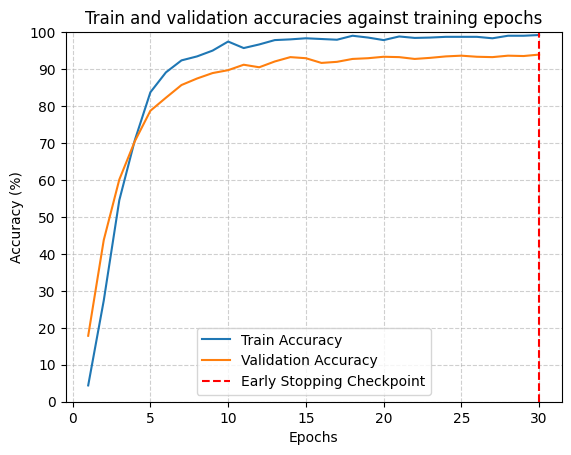

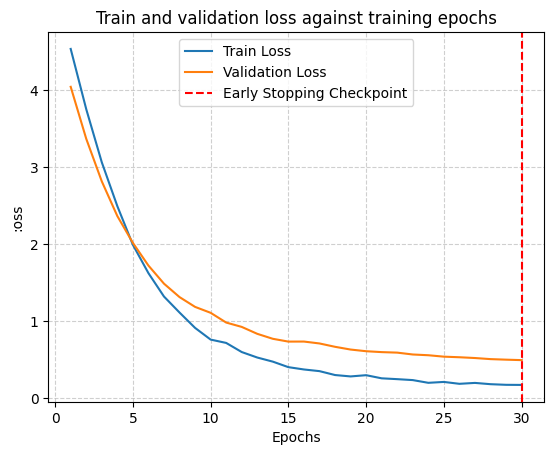

In [24]:
# Plot train and validation accuracies against training epochs
plt.figure(1)
plt.clf()
def to_percent(acc):
    """Convert accuracy value to percentage, handling both tensors and floats"""
    if torch.is_tensor(acc):
        return acc.cpu().item() * 100
    return acc * 100  # if it's already a float

# Convert all accuracy values to percentages
train_acc = [to_percent(acc) for acc in tr_acc]
val_acc = [to_percent(acc) for acc in vl_acc]

# Plot the curves
plt.plot(range(1, len(tr_acc) + 1), train_acc, label='Train Accuracy')
plt.plot(range(1, len(vl_acc) + 1), val_acc, label='Validation Accuracy')

# Find position of lowest validation loss
minposs = vl_loss.index(min(vl_loss))+1
plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title ('Train and validation accuracies against training epochs')
plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


# Plot train and validation loss against training epochs
fig = plt.figure(2)
plt.plot(range(1,len(tr_loss)+1), tr_loss, label='Train Loss')
plt.plot(range(1,len(vl_loss)+1), vl_loss, label='Validation Loss')

# Find position of lowest validation loss
minposs = vl_loss.index(min(vl_loss))+1
plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel(':oss')
plt.title ('Train and validation loss against training epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Test evaluation

In [25]:
# Final evaluation
test_loss, test_acc = test_loop(test_loader, trained_model, criterion)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")


Final Test Accuracy: 91.40%
Final Test Loss: 0.5813


### Visualizing the model predictions

The `visualize_model` function is designed to display predictions of the provided model on images from the validation dataset.

### Parameters:

- **model**: The trained neural network model whose predictions are to be visualized.
- **num_images**: The number of images on which predictions are to be displayed (default is 6).

### Process:

1. **Model State**:
    - The current training state of the model (either training or evaluation) is stored in the `was_training` variable.

2. **Set Model to Evaluation Mode**:
    - The model is set to evaluation mode using `model.eval()`. This ensures that operations like dropout are not applied during inference.

3. **Image Counter**:
    - `images_so_far` keeps track of the number of images processed.

4. **Visualization Setup**:
    - A new matplotlib figure is initialized to display the images and their predictions.

5. **Iterate Over Validation Data**:
    - The function iterates over batches of images from the validation dataset.
    - For each batch:
        - The images and labels are transferred to the appropriate device (either CPU or GPU).
        - The model makes predictions on the batch of images.
        - The predicted class indices are extracted using `torch.max`.

6. **Display Predictions**:
    - For each image in the batch:
        - A subplot is created for the image.
        - The image is displayed along with its predicted class label.
        - If the number of images displayed reaches `num_images`, the function returns.

7. **Restore Model State**:
    - Before exiting the function, the model's training state is restored to its original value using `model.train(mode=was_training)`.

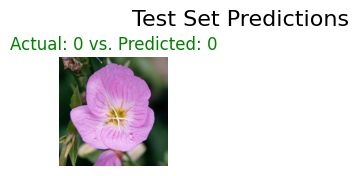

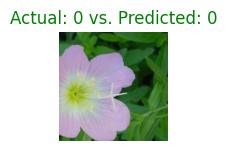

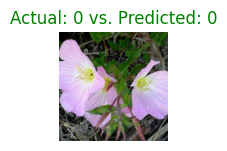

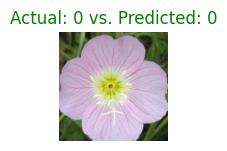

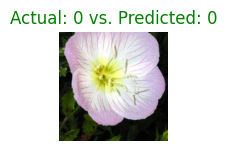

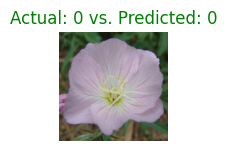

In [27]:
# Visualize test set predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    plt.suptitle("Test Set Predictions", fontsize=16)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')

				# Highlight incorrect predictions in red
                title_color = 'green' if preds[j] == labels[j] else 'red'
                ax.set_title(
                    f'Actual: {labels[j].item()} vs. Predicted: {preds[j].item()}',
                    color=title_color,
                )

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(trained_model)
plt.show()

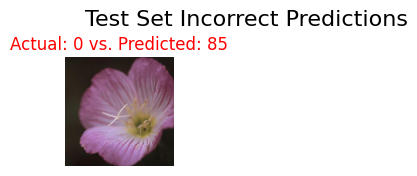

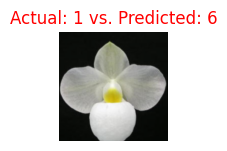

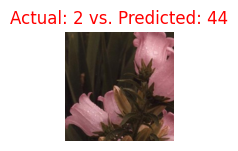

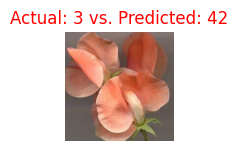

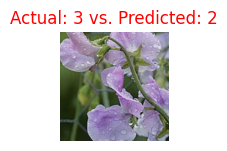

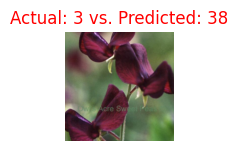

In [28]:
# Visualize test set incorrect predictions
def visualize_incorrect_prediction(model, num_images=6):
    was_training = model.training
    model.eval()
    incorrect_count = 0
    fig = plt.figure()
    plt.suptitle("Test Set Incorrect Predictions", fontsize=16)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if labels[j] != preds[j].item():
                    incorrect_count += 1
                    ax = plt.subplot(num_images//2, 2, incorrect_count)
                    ax.axis('off')

					# Highlight incorrect predictions in red
                    title_color = 'green' if preds[j] == labels[j] else 'red'
                    ax.set_title(
                        f'Actual: {labels[j].item()} vs. Predicted: {preds[j].item()}',
                        color=title_color,
                    )

                    imshow(inputs.cpu().data[j])

                    if incorrect_count == num_images:
                        model.train(mode=was_training)
                        return
        model.train(mode=was_training)

visualize_incorrect_prediction(trained_model)
plt.show()